In [1]:
import numpy as np
import re
import open3d as o3d
import os

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [58]:
def parse_x_file(filepath):
    with open(filepath, 'r') as f:
        text = f.read()

    # --- Извлечение RV_Calibration (матрица перехода из мировой системы координат в систему координат камеры) ---
    rv_match = re.search(r'RV_Calibration\s*{\s*((?:-?\d+\.\d+[,;]\s*){16})', text)
    if not rv_match:
        raise ValueError("RV_Calibration не найдена")

    matrix_values = list(map(float, re.findall(r'-?\d+\.\d+', rv_match.group(1))))
    rv_matrix = np.array(matrix_values).reshape((4, 4))

    # Извлечение FrameTransformMatrix (матрица перехода из локальных координат в мировые)
    frame_match = re.search(r'FrameTransformMatrix\s*{\s*((?:-?\d+\.\d+[,;]\s*){16})', text, re.DOTALL)
    if not frame_match:
        raise ValueError("FrameTransformMatrix не найдена")
    frame_values = list(map(float, re.findall(r'-?\d+\.\d+', frame_match.group(1))))
    frame_matrix = np.array(frame_values).reshape((4, 4))
    

    # --- Извлечение количества вершин ---
    mesh_header = re.search(r'Mesh\s+\w+\s*{\s*(\d+);', text)
    if not mesh_header:
        raise ValueError("Mesh-блок не найден")
    num_vertices = int(mesh_header.group(1))
    print(f"num_vertices: {num_vertices}")

    # --- Извлечение самих вершин (Nx3) ---
    vertex_pattern = r'(-?\d+\.\d+);(-?\d+\.\d+);(-?\d+\.\d+);[;,]'
    vertex_data = re.findall(vertex_pattern, text)
    if len(vertex_data) < num_vertices:
        raise ValueError("Недостаточно вершин найдено")
    vertices = np.array(vertex_data[:num_vertices], dtype=np.float32)

    # --- Извлечение количества треугольников ---
    face_start_idx = text.find(vertex_data[num_vertices - 1][2])
    face_block_match = re.search(r'(\d+);\s*(3;[^\}]+?);', text[face_start_idx:], re.DOTALL)
    if not face_block_match:
        raise ValueError("Блок треугольников не найден")
    num_faces = int(face_block_match.group(1))
    print(f"num_faces: {num_faces}")

    # --- Извлечение индексов треугольников ---
    face_pattern = r'3;(\d+),(\d+),(\d+);[;,]'
    face_data = re.findall(face_pattern, text)
    if len(face_data) < num_faces:
        raise ValueError("Недостаточно треугольников найдено")
    faces = np.array(face_data[:num_faces], dtype=np.int32)

    # --- Извлечение UV-координат ---
    uv_match = re.search(r'MeshTextureCoords\s*{\s*(\d+);', text)
    if not uv_match:
        raise ValueError("UV-координаты не найдены")
    num_uvs = int(uv_match.group(1))
    print(f"num_uvs: {num_uvs}")
    uv_data = re.findall(r'(-?\d+\.\d+);(-?\d+\.\d+);[;,]', text[uv_match.start():])
    if len(uv_data) < num_uvs:
        raise ValueError("Недостаточно UV-координат")
    uvs = np.array(uv_data[:num_uvs], dtype=np.float32)

    return {
        "vertices": vertices,
        "faces": faces,
        "uvs": uvs,
        "rv_matrix": rv_matrix,
        "frame_matrix": frame_matrix,
    }


def apply_transformation(vertices, matrix4x4):
    # (x, y, z) -> (x, y, z, 1)
    ones = np.ones((vertices.shape[0], 1), dtype=np.float32)
    vertices_hom = np.hstack([vertices, ones])  # (N, 4)

    # Применим калибровку
    transformed = vertices_hom @ matrix4x4.T  # (N, 4)
    return transformed[:, :3]

In [15]:
def create_voxel_grid(points, grid_size=256):
    # Нормализация координат в [0, 1]
    min_bounds = points.min(axis=0)
    max_bounds = points.max(axis=0)
    norm_points = (points - min_bounds) / (max_bounds - min_bounds + 1e-5)

    # Масштабирование в voxel grid
    voxel_coords = np.floor(norm_points * (grid_size - 1)).astype(int)

    # Заполнение воксельной сетки
    voxels = np.zeros((grid_size, grid_size, grid_size), dtype=bool)
    for x, y, z in voxel_coords:
        voxels[x, y, z] = True

    return voxels

In [5]:
def visualize_voxel_grid(voxels):
    coords = np.argwhere(voxels)
    pc = o3d.geometry.PointCloud()
    pc.points = o3d.utility.Vector3dVector(coords)
    o3d.visualization.draw_geometries([pc])

In [59]:
VOXEL_GRID_SIZE = 256

In [60]:
filepath = os.path.abspath('data\\teapot_1.x')

In [61]:
raw_data = parse_x_file(filepath)

num_vertices: 200310
num_faces: 379304
num_uvs: 200310


In [62]:
raw_data.get('rv_matrix')

array([[ 0.672113, -0.737551,  0.065438,  0.      ],
       [ 0.730691,  0.674961,  0.10256 ,  0.      ],
       [-0.119812, -0.021117,  0.992572,  0.      ],
       [ 0.      ,  0.      ,  0.      ,  1.      ]])

In [63]:
raw_data.get('frame_matrix')

array([[ 0.641019, -0.763945, -0.074042,  0.      ],
       [ 0.758899,  0.645281, -0.087658,  0.      ],
       [ 0.114744, -0.      ,  0.993395,  0.      ],
       [ 0.      ,  0.      ,  0.      ,  1.      ]])

In [66]:
raw_data.get('vertices')

array([[  1.980963,  -1.672549,  28.428423],
       [  2.156728,  -1.461856,  28.151258],
       [  2.333155,  -1.251905,  28.059855],
       ...,
       [106.13634 , -67.10736 , -12.332775],
       [106.29931 , -66.91276 , -12.299887],
       [106.621   , -66.52091 , -12.251754]],
      shape=(200310, 3), dtype=float32)

In [64]:
world_transform = apply_transformation(raw_data.get('vertices'), raw_data.get('frame_matrix'))

In [65]:
world_transform

array([[ 4.42673078e-01, -2.06789196e+00,  2.84679568e+01],
       [ 4.14905753e-01, -1.77425218e+00,  2.82127910e+01],
       [ 3.74375422e-01, -1.49687228e+00,  2.81422347e+01],
       ...,
       [ 1.20214885e+02,  3.83247217e+01, -7.28092514e-02],
       [ 1.20168252e+02,  3.85710913e+01, -2.14380655e-02],
       [ 1.20071551e+02,  3.90638555e+01,  6.32893030e-02]],
      shape=(200310, 3))

In [67]:
transformed = apply_transformation(world_transform, raw_data.get('rv_matrix'))

In [68]:
transformed

array([[  3.68558827,   1.84738446,  28.24712696],
       [  3.43365364,   1.99912072,  27.99098259],
       [  3.19721379,   2.14948993,  27.91994896],
       ...,
       [ 52.52678562, 113.70015964, -15.28475736],
       [ 52.3170943 , 113.83764362, -15.23338312],
       [ 51.8942061 , 114.10827143, -15.14810489]], shape=(200310, 3))

In [33]:
voxels = create_voxel_grid(transformed, VOXEL_GRID_SIZE)

In [34]:
visualize_voxel_grid(voxels)

In [18]:
print("Testing IO for meshes ...")
knot_data = o3d.data.KnotMesh()
mesh = o3d.io.read_triangle_mesh(knot_data.path)
print(mesh)

Testing IO for meshes ...
[Open3D INFO] Downloading https://github.com/isl-org/open3d_downloads/releases/download/20220201-data/KnotMesh.ply
[Open3D INFO] Downloaded to C:\Users\cabam/open3d_data/download/KnotMesh/KnotMesh.ply
TriangleMesh with 1440 points and 2880 triangles.


In [20]:
knot_data.path

'C:\\Users\\cabam/open3d_data/extract/KnotMesh/KnotMesh.ply'

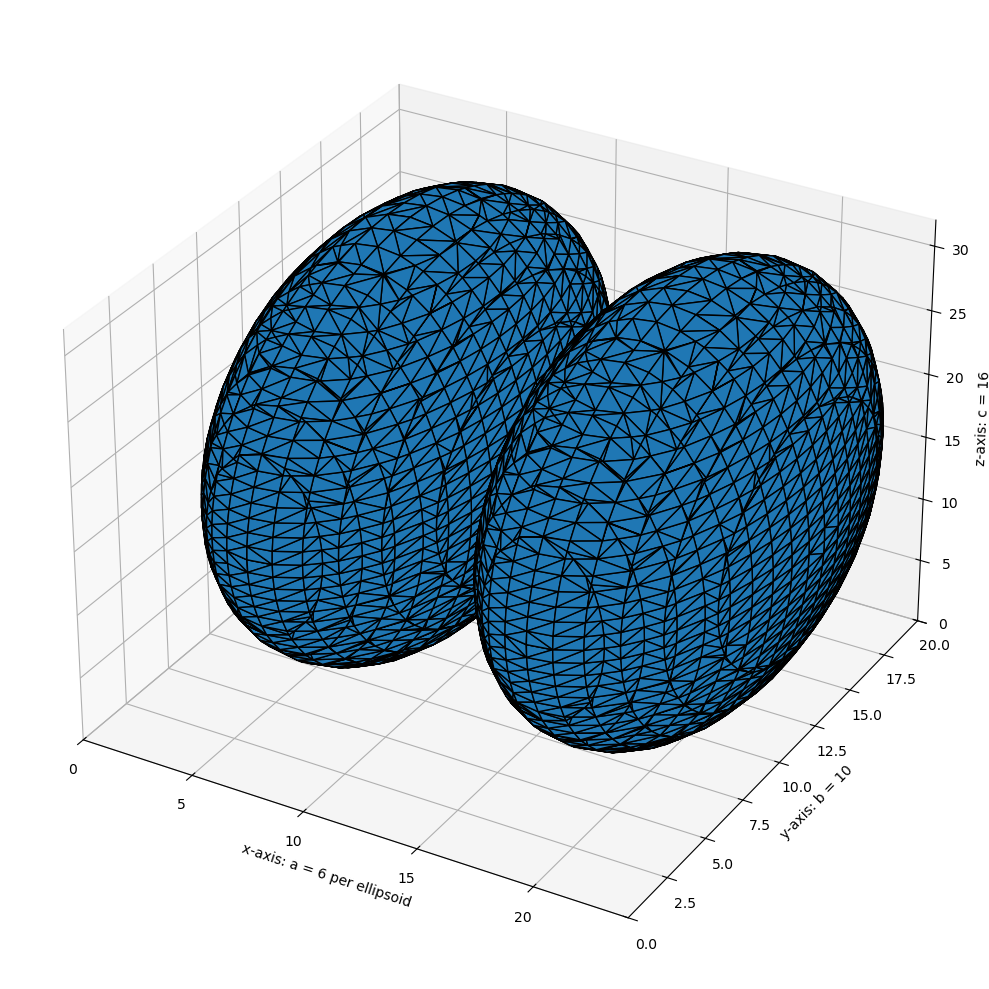

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from skimage import measure
from skimage.draw import ellipsoid


# Generate a level set about zero of two identical ellipsoids in 3D
ellip_base = ellipsoid(6, 10, 16, levelset=True)
ellip_double = np.concatenate((ellip_base[:-1, ...], ellip_base[2:, ...]), axis=0)

# Use marching cubes to obtain the surface mesh of these ellipsoids
verts, faces, normals, values = measure.marching_cubes(ellip_double, 0)

# Display resulting triangular mesh using Matplotlib. This can also be done
# with mayavi (see skimage.measure.marching_cubes docstring).
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Fancy indexing: `verts[faces]` to generate a collection of triangles
mesh = Poly3DCollection(verts[faces])
mesh.set_edgecolor('k')
ax.add_collection3d(mesh)

ax.set_xlabel("x-axis: a = 6 per ellipsoid")
ax.set_ylabel("y-axis: b = 10")
ax.set_zlabel("z-axis: c = 16")

ax.set_xlim(0, 24)  # a = 6 (times two for 2nd ellipsoid)
ax.set_ylim(0, 20)  # b = 10
ax.set_zlim(0, 32)  # c = 16

plt.tight_layout()
plt.show()